In [216]:
def nms(bounding_boxes, confidence_score, threshold):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score

In [218]:
import cv2
import numpy as np

path = "../data/Cell_Templates/cell"

def read_template(path):
    templ = []
    for i in range(1,36):
        templ.append(cv2.imread(path+str(i)+".png", 0))
    return templ
	
#path = "../cell_templates/cell"
template_list = read_template(path)

In [219]:
print(len(template_list))

35


In [220]:
template_list[0]

array([[ 26,  46,  56,  70,  75,  63,  88,  93,  66,  36,  32,  31,  36],
       [ 38,  53,  62,  82,  85, 115, 171, 171, 159, 112,  52,  41,  41],
       [ 41,  49,  82, 124, 171, 171, 171, 171, 171, 171, 121,  56,  63],
       [ 34,  63, 112, 171, 171, 171, 171, 171, 171, 171, 171, 114,  88],
       [ 30,  78, 136, 171, 171, 171, 171, 171, 171, 171, 171, 140, 123],
       [ 26,  66, 172, 171, 171, 171, 171, 171, 171, 171, 171,  98, 130],
       [ 24,  77, 171, 171, 171, 171, 171, 164, 133, 115,  83,  66, 124],
       [ 24,  63, 171, 171, 171, 171, 153,  70,  52,  36,  35,  42, 109],
       [ 21,  49, 171, 171, 171, 118,  72,  34,  24,  24,  26,  45,  97],
       [ 23,  35,  85, 153, 105,  43,  34,  25,  22,  26,  26,  48, 107],
       [ 18,  22,  31,  46,  36,  31,  35,  27,  25,  38,  31,  43,  72]],
      dtype=uint8)

In [222]:
img_rgb = cv2.imread('00A-1.jpg')
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY) 

bounding_boxes = []
confidence_score = []
for template in template_list:
    h, w = template.shape[::]
    print(h,w)
    res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)
    threshold = 0.70
    loc = np.where( res >= threshold)
    for pt in zip(*loc[::-1]):
        bounding_boxes.append((pt[0], pt[1], pt[0] + w, pt[1] + h ))
        confidence_score.append(res[pt[1]][pt[0]])

11 13
12 12
12 12
15 12
14 16
15 11
18 11
13 11
14 14
11 9
8 15
9 14
10 15
13 15
10 16
12 11
14 14
11 14
15 12
16 16
14 15
12 14
10 14
12 14
12 14
10 13
14 12
17 13
10 12
17 16
14 9
14 11
12 12
11 10
15 7


In [223]:
for (start_x, start_y, end_x, end_y), confidence in zip(bounding_boxes, confidence_score):
    cv2.rectangle(img_rgb, (start_x, start_y), (end_x, end_y), (0, 255, 255), 2)

picked_boxes, picked_score = nms(bounding_boxes, confidence_score, 0.05)
img_rgb1 = cv2.imread('00A-1.jpg')

for (start_x, start_y, end_x, end_y), confidence in zip(picked_boxes, picked_score):
    cv2.rectangle(img_rgb1, (start_x, start_y), (end_x, end_y), (0, 255, 255), 2)

cv2.imshow("Template Matching Result", img_rgb)
cv2.imshow("NMS Result", img_rgb1)
cv2.waitKey()
cv2.destroyAllWindows()

In [224]:
#resizing images
scale_percent = 40
width = int(img_rgb1.shape[1] * scale_percent / 100)
height = int(img_rgb1.shape[0] * scale_percent / 100)
dim = (width, height)

img_rgb2 = cv2.imread('00A-1.jpg')

org_image = cv2.resize(img_rgb2, dim, interpolation = cv2.INTER_AREA)
resized = cv2.resize(img_rgb1, dim, interpolation = cv2.INTER_AREA)
 
print('Resized Dimensions : ',resized.shape)
cv2.imshow("Original image", org_image)
cv2.imshow("Resized image", resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

Resized Dimensions :  (822, 927, 3)


In [225]:
#finding centroid from the bounding boxes
#x_min, y_min, width, height
def find_centroid(picked_points):
    centroids = []
    for idx, bbox in enumerate(picked_points):
        centroids.append([bbox[0]+(bbox[2]/2), bbox[1]+(bbox[3]/2)])
    return centroids

In [226]:
centroid = find_centroid(picked_boxes)
centroid[:10]

[[2436.0, 807.5],
 [1456.5, 2375.0],
 [2140.5, 332.0],
 [1360.5, 2346.5],
 [1327.5, 2334.5],
 [1648.5, 2444.0],
 [754.0, 2974.0],
 [1536.0, 2387.0],
 [1452.5, 225.5],
 [2442.0, 842.0]]

In [227]:
import matplotlib.pyplot as plt

In [228]:
x_arr = np.array(centroid)

In [229]:
x_arr[:,0][:30]

array([2436. , 1456.5, 2140.5, 1360.5, 1327.5, 1648.5,  754. , 1536. ,
       1452.5, 2442. , 1392. , 1665.5, 2305.5,   93. , 2094. ,  636. ,
       2101. , 1201.5, 2155.5,  795. , 1146. , 2214. , 1695. , 2224.5,
       2005.5, 1929. , 1629. , 1147.5, 2248.5, 2311.5])

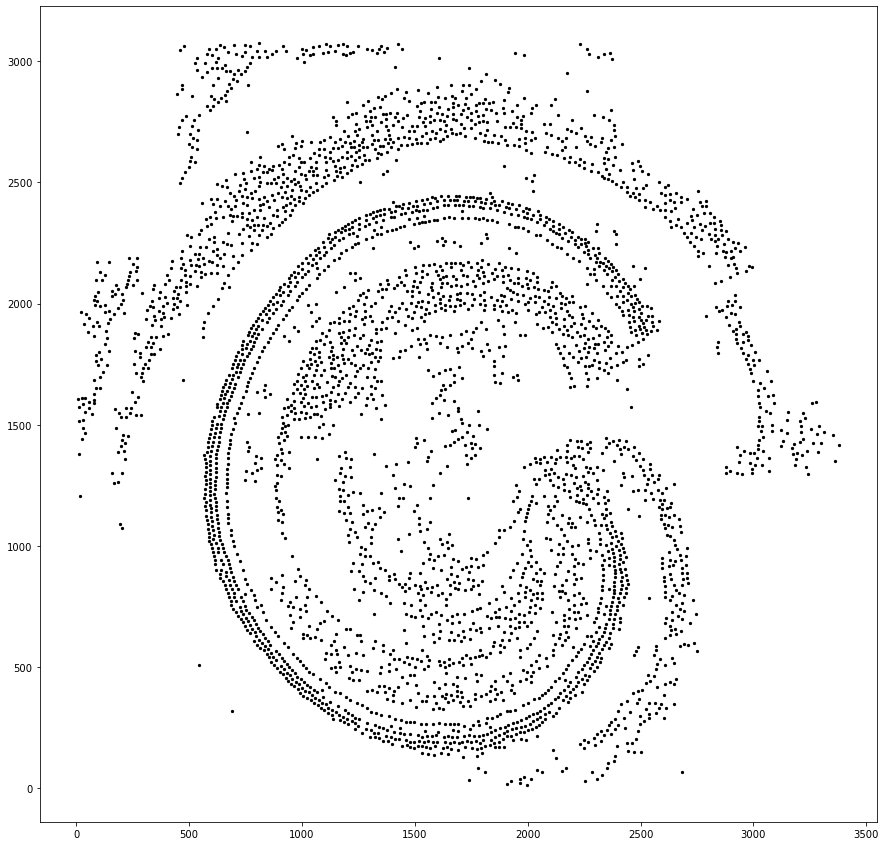

In [230]:
plt.figure(figsize=(15,15))
plt.scatter(x_arr[ : , 0], x_arr[ :, 1], s = 5, c = 'k')

In [232]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [233]:
x_tr = StandardScaler().fit_transform(x_arr)

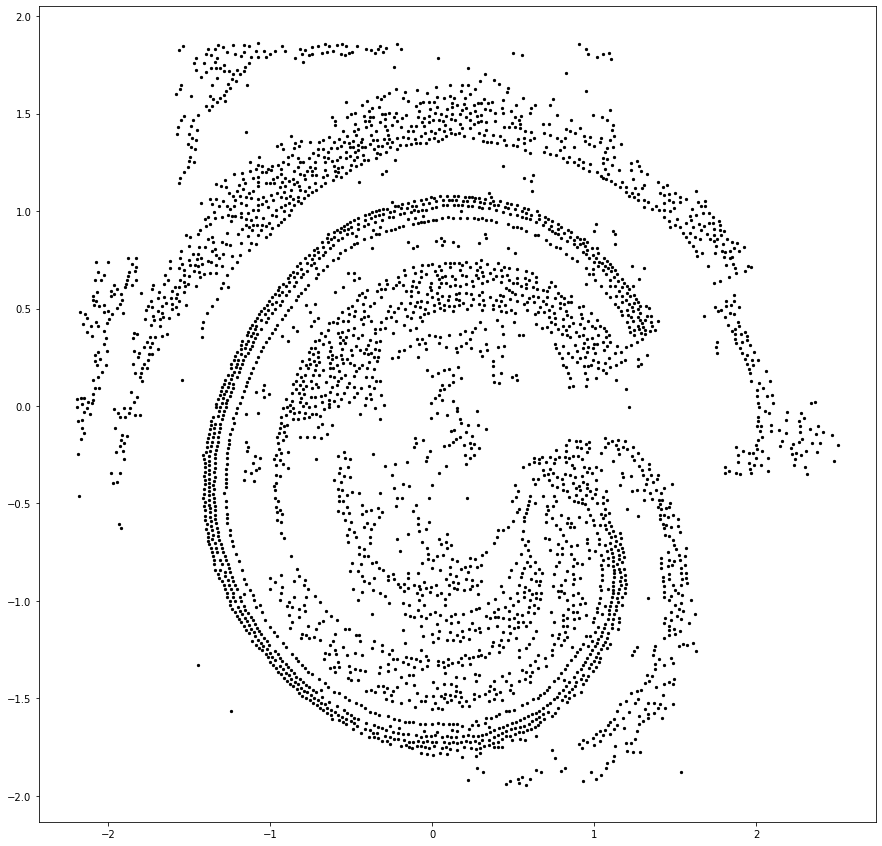

In [234]:
plt.figure(figsize=(15,15))
plt.scatter(x_tr[ : , 0], x_tr[ :, 1], s = 5, c = 'k')

In [244]:
y_pred = DBSCAN(eps=0.1, min_samples=20).fit_predict(x_tr)

In [245]:
len(list(y_pred))

3876

In [246]:
set(list(y_pred))

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [247]:
unique, counts = np.unique(list(y_pred), return_counts=True)
print(dict(zip(unique, counts)))

{-1: 1553, 0: 1137, 1: 379, 2: 84, 3: 277, 4: 87, 5: 177, 6: 51, 7: 20, 8: 38, 9: 33, 10: 22, 11: 18}


In [248]:
#colors = {-1:'tab:blue', 0:'tab:orange', 1:'tab:green', 2:'tab:red', 3:'tab:purple', 4:'tab:brown', 5:'tab:pink', 6:'tab:black', 7:'tab:yellow', 8:'tab:yellow', 9:'tab:yellow', 10:'tab:yellow', 11:'tab:yellow', 12:'tab:yellow', 13:'tab:yellow', 14:'tab:yellow', 15:'tab:yellow', 16:'tab:yellow', 17:'tab:yellow', 18:'tab:yellow', 19:'tab:yellow', 20:'tab:yellow', 21:'tab:yellow', 22:'tab:yellow', 23:'tab:yellow',  24:'tab:yellow'}
#[colors[k] for k in y_pred]

In [249]:
len(unique)

13

In [250]:
colors = {-1:'tab:blue', 0:'tab:orange', 1:'tab:green', 2:'tab:red', 3:'tab:purple', 4:'tab:brown', 5:'tab:pink'}
uniq_len = len(unique)
while uniq_len > len(colors.keys()):
    #print(uniq_len, len(colors.keys()))
    colors[len(colors.keys())-1] = 'tab:grey'


In [251]:
colors

{-1: 'tab:blue',
 0: 'tab:orange',
 1: 'tab:green',
 2: 'tab:red',
 3: 'tab:purple',
 4: 'tab:brown',
 5: 'tab:pink',
 6: 'tab:grey',
 7: 'tab:grey',
 8: 'tab:grey',
 9: 'tab:grey',
 10: 'tab:grey',
 11: 'tab:grey'}

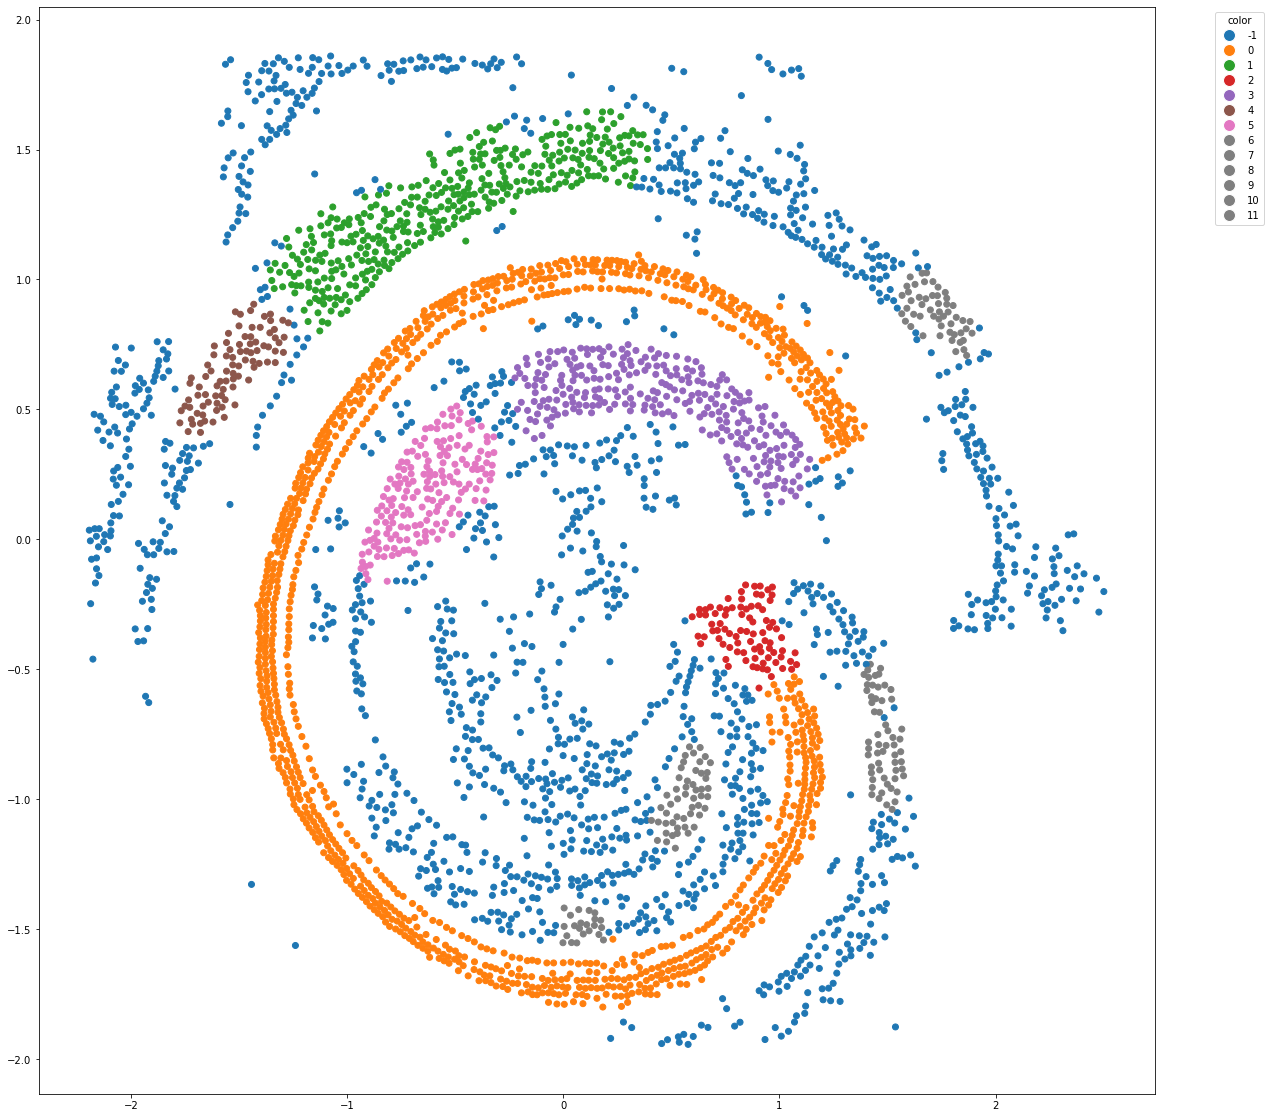

In [252]:
from matplotlib.lines import Line2D 

fig, ax = plt.subplots(figsize=(20, 20))

#colors = {-1:'tab:blue', 0:'tab:orange', 1:'tab:green', 2:'tab:red', 3:'tab:purple', 4:'tab:brown', 5:'tab:pink', 6:'tab:grey', 7:'tab:purple', 8:'tab:purple',  9:'tab:purple',  10:'tab:purple',  11:'tab:purple', 12:'tab:purple', 13:'tab:purple'}


ax.scatter(x_tr[:,0], x_tr[:,1], c=[colors[k] for k in y_pred])

# add a legend
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=12) for k, v in colors.items()]
ax.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [113]:
y_pred = DBSCAN(eps=0.1, min_samples=15, metric= 'manhattan').fit_predict(x_tr)

In [114]:
len(list(y_pred))

2213

In [115]:
set(list(y_pred))

{-1, 0, 1, 2, 3, 4, 5, 6}

In [116]:
unique, counts = np.unique(list(y_pred), return_counts=True)
print(dict(zip(unique, counts)))

{-1: 1108, 0: 229, 1: 559, 2: 180, 3: 97, 4: 16, 5: 9, 6: 15}


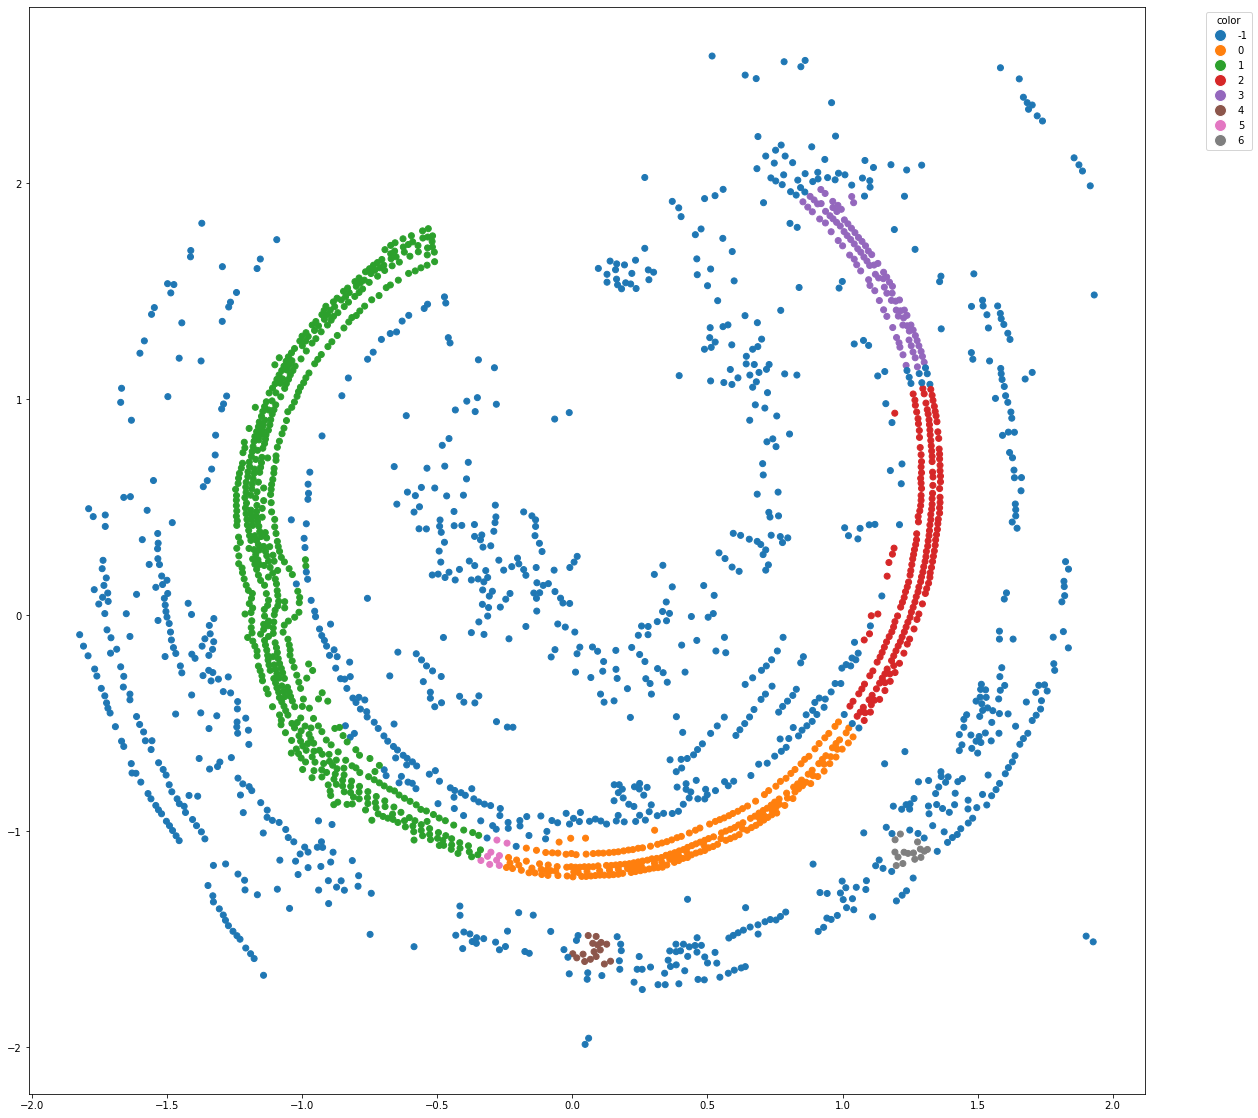

In [117]:
from matplotlib.lines import Line2D 

fig, ax = plt.subplots(figsize=(20, 20))

colors = {-1:'tab:blue', 0:'tab:orange', 1:'tab:green', 2:'tab:red', 3:'tab:purple', 4:'tab:brown', 5:'tab:pink', 6:'tab:grey'}#, 7:'tab:purple'}


ax.scatter(x_tr[:,0], x_tr[:,1], c=[colors[k] for k in y_pred])

# add a legend
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=12) for k, v in colors.items()]
ax.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()